In [1]:
# Imports
import re
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from peft import get_peft_model, LoraConfig, TaskType


In [2]:
# Configuration Class
class Config:
    """
    Configuration class containing all tunable hyperparameters and settings.
    """
    DATASET_NAME = "cnn_dailymail"
    DATASET_VERSION = "3.0.0"
    SAMPLE_SIZE = 10000         # Use a subset (10K samples)
    MAX_INPUT_LENGTH = 512      # Maximum token length for articles
    MAX_TARGET_LENGTH = 64      # Maximum token length for headlines
    BATCH_SIZE = 8              # Batch size for DataLoader
    NUM_WORKERS = 2             # Number of workers for DataLoader
    LEARNING_RATE = 3e-4        # Learning Rate
    TRAIN_EPOCHS = 3            # Number of Epochs for training

    # paths
    output_dir = './results'

# Instantiate the configuration
config = Config()


In [3]:
# Data Loading & Analysis
# Load the CNN/DailyMail dataset using Hugging Face's datasets library.
print("Loading dataset...")
dataset = load_dataset(Config.DATASET_NAME, Config.DATASET_VERSION)

# Print dataset splits and sizes
print("Dataset splits and sizes:")
for split in dataset.keys():
    print(f"{split} split has {len(dataset[split])} samples.")


Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset splits and sizes:
train split has 287113 samples.
validation split has 13368 samples.
test split has 11490 samples.



Train Sample Data Analysis:
Number of samples: 10000
Average article length (words): 620.28
Average headline length (words): 44.63


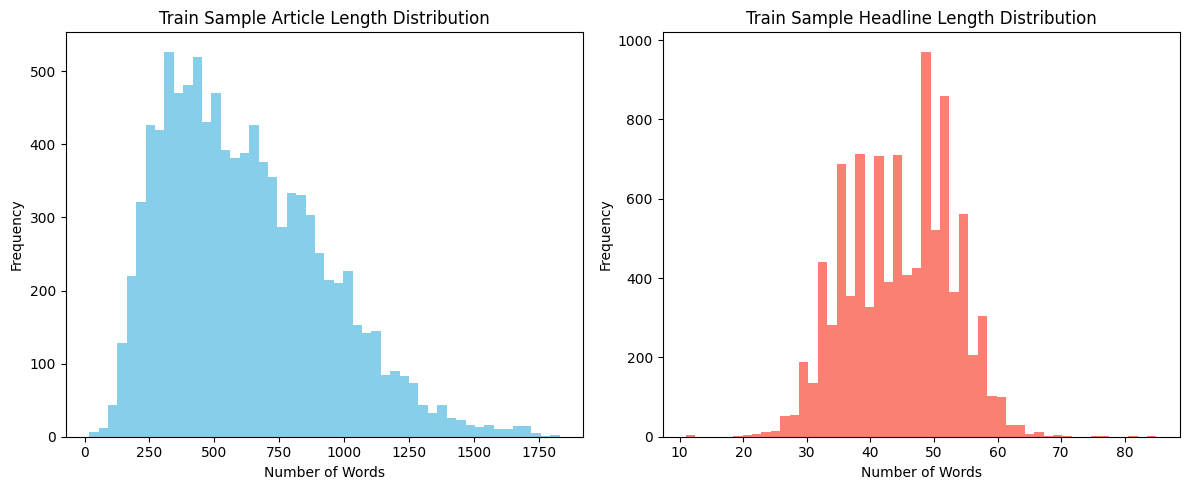


Sample Data:

Sample 1:
Article snippet: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on  ...
Headline: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .
-----

Sample 2:
Article snippet: Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail w ...
Headline: Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for cha

In [4]:
# For analysis, we will work with a subset of the training data.
train_sample = dataset['train'].select(range(min(Config.SAMPLE_SIZE, len(dataset['train']))))

def analyze_dataset(split_data, split_name="Train"):
    """
    Analyze dataset by calculating the average number of words in articles and headlines,
    and plotting their distributions.
    """
    # Compute word lengths for articles and headlines
    article_lengths = [len(item['article'].split()) for item in split_data]
    headline_lengths = [len(item['highlights'].split()) for item in split_data]

    print(f"\n{split_name} Data Analysis:")
    print(f"Number of samples: {len(split_data)}")
    print(f"Average article length (words): {np.mean(article_lengths):.2f}")
    print(f"Average headline length (words): {np.mean(headline_lengths):.2f}")

    # Plot distributions of article and headline lengths
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(article_lengths, bins=50, color='skyblue')
    plt.title(f"{split_name} Article Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(headline_lengths, bins=50, color='salmon')
    plt.title(f"{split_name} Headline Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Analyze the training sample
analyze_dataset(train_sample, "Train Sample")

# Print a few sample examples for manual inspection
print("\nSample Data:")
for i in range(3):
    print(f"\nSample {i+1}:")
    print("Article snippet:", train_sample[i]['article'][:200], "...")
    print("Headline:", train_sample[i]['highlights'])
    print("-----")


In [5]:
# Preprocessing
def clean_text(text):
    """
    Basic text cleaning function:
    - Strips whitespace from the ends.
    - Replaces multiple spaces/newlines with a single space.
    """
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def preprocess_function(example):
    """
    Preprocess a single example by cleaning both the article and the headline.
    """
    example['article'] = clean_text(example['article'])
    example['highlights'] = clean_text(example['highlights'])
    return example

# Apply preprocessing to the training sample.
# (Using map() is efficient and leverages multi-threading if available.)
print("\nApplying preprocessing to the training sample...")
train_sample = train_sample.map(preprocess_function)

# Check cleaned data on a sample
print("\nPost-Preprocessing Sample:")
print("Article snippet:", train_sample[0]['article'][:200], "...")
print("Headline:", train_sample[0]['highlights'])



Applying preprocessing to the training sample...

Post-Preprocessing Sample:
Article snippet: LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on  ...
Headline: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund .


In [6]:
# Dataset/Dataloader
class CNNDailyMailDataset(Dataset):
    """
    Custom PyTorch Dataset to wrap the preprocessed CNN/DailyMail data.
    Each item is a dictionary containing an 'article' and its corresponding 'headline'.
    """
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Return a dictionary with the input article and target headline.
        item = self.dataset[idx]
        return {"article": item['article'], "headline": item['highlights']}

# Instantiate the PyTorch dataset using the training sample
train_data = CNNDailyMailDataset(train_sample)

# Create a DataLoader for the training data.
train_dataloader = DataLoader(
    train_data,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=Config.NUM_WORKERS
)

# Verify DataLoader output by fetching one batch.
batch = next(iter(train_dataloader))
print("\nDataLoader Batch Sample:")
print("Articles (first 2):", batch["article"][:2])
print("Headlines (first 2):", batch["headline"][:2])



DataLoader Batch Sample:
Articles (first 2): ['(CNN) -- The American Psychological Association concluded Wednesday that there is little evidence that efforts to change a person\'s sexual orientation from gay or lesbian to heterosexual are effective. The report looks at 87 studies conducted between 1960 and 2007. In addition, the 138-page report -- covering 87 peer-reviewed studies -- said that such efforts may cause harm. "Contrary to claims of sexual orientation change advocates and practitioners, there is insufficient evidence to support the use of psychological interventions to change sexual orientation," said Judith M. Glassgold, chairwoman of the task force that presented the report at the group\'s annual meeting in Toronto, Canada. The Washington-based association represents more than 150,000 members. "At most, certain studies suggested that some individuals learned how to ignore or not act on their homosexual attractions. Yet, these studies did not indicate for whom this was po

In [7]:
# Model Setup

# Use BART-base
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Set up PEFT (LoRA configuration) to reduce trainable parameters
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # Task type for seq2seq
    r=8,                            # Low-rank decomposition dimension
    lora_alpha=32,                  # Scaling factor
    lora_dropout=0.1                # Dropout rate for LoRA layers
)
model = get_peft_model(model, lora_config)

# Print number of trainable vs total parameters to verify PEFT is applied
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print("Trainable parameters:", trainable_params)
print("Total parameters:", total_params)


Trainable parameters: 442368
Total parameters: 139862784


In [8]:
# Training Preparation: Tokenization & Data Collation

# Define tokenization function for our dataset (articles as inputs and headlines as targets)
def tokenize_function(example):
    # Tokenize the input article
    model_inputs = tokenizer(example['article'],
                             max_length=Config.MAX_INPUT_LENGTH,
                             truncation=True)
    # Tokenize the target headline
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example['highlights'],
                           max_length=Config.MAX_TARGET_LENGTH,
                           truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Tokenizing training dataset...")
train_tokenized = train_sample.map(tokenize_function, batched=True, remove_columns=["article", "highlights"])

# For validation, use a smaller subset
print("Preparing and tokenizing validation dataset...")
val_sample = dataset['validation'].select(range(min(1000, len(dataset['validation']))))
val_sample = val_sample.map(preprocess_function)
val_tokenized = val_sample.map(tokenize_function, batched=True, remove_columns=["article", "highlights"])

# Set format for PyTorch tensors
train_tokenized.set_format(type="torch")
val_tokenized.set_format(type="torch")

# Create a data collator that dynamically pads inputs
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


Tokenizing training dataset...
Preparing and tokenizing validation dataset...


In [20]:
# Training & Evaluation Setup

# Define training arguments (with mixed precision to help reduce memory usage)
training_args = TrainingArguments(
    output_dir=Config.output_dir,
    per_device_train_batch_size=Config.BATCH_SIZE,
    evaluation_strategy="no",
    logging_steps=100,
    learning_rate=Config.LEARNING_RATE,
    num_train_epochs=Config.TRAIN_EPOCHS,
    save_total_limit=1,
    fp16=True,  # Enable mixed-precision training to save memory
)

# Initialize the Trainer with the model, datasets, and our configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-3cb28a0de4e0>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
# Training
print("Starting training...")
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bunnymesu369 (bunnymesu369-bunny) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
100,3.012400
200,2.726300
300,2.658400
400,2.650400
500,2.570200
600,2.612200
700,2.560300
800,2.527200
900,2.523400
1000,2.503700


TrainOutput(global_step=3750, training_loss=2.498972821044922, metrics={'train_runtime': 576.5096, 'train_samples_per_second': 52.037, 'train_steps_per_second': 6.505, 'total_flos': 9186815508480000.0, 'train_loss': 2.498972821044922, 'epoch': 3.0})

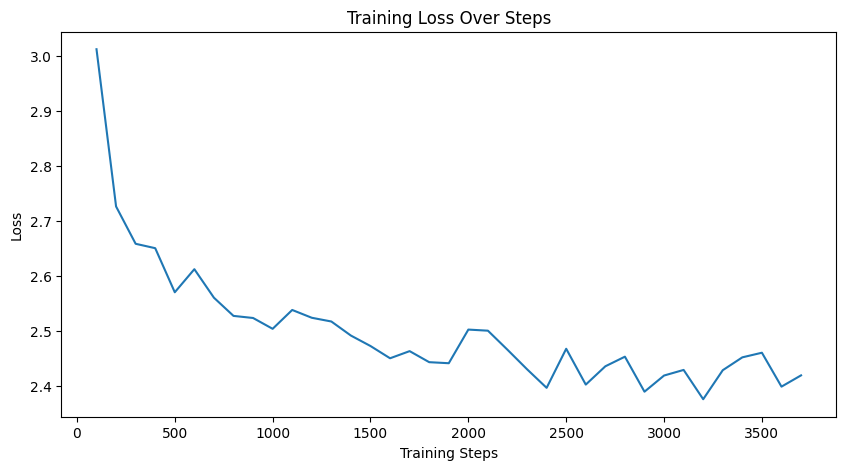

In [14]:
# Visualization: Training Loss Plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training loss if available in the Trainer's log history
if trainer.state.log_history:
    logs = trainer.state.log_history
    df_logs = pd.DataFrame(logs)
    if "loss" in df_logs.columns:
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df_logs, x="step", y="loss")
        plt.title("Training Loss Over Steps")
        plt.xlabel("Training Steps")
        plt.ylabel("Loss")
        plt.show()
    else:
        print("No training loss data available for visualization.")
else:
    print("No training log history available.")


In [21]:
# Evaluation
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


Evaluation results: {'eval_loss': 2.2758119106292725, 'eval_model_preparation_time': 0.0231, 'eval_runtime': 8.9459, 'eval_samples_per_second': 111.783, 'eval_steps_per_second': 13.973}


In [13]:
# Inference
def generate_headline(article_text):
    """
    Generate a headline for a given article text.
    """
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(article_text,
                       return_tensors="pt",
                       max_length=Config.MAX_INPUT_LENGTH,
                       truncation=True).to(model.device)
    outputs = model.generate(**inputs, max_length=Config.MAX_TARGET_LENGTH, num_beams=4, early_stopping=True)
    headline = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return headline

# Test inference on a sample article from the validation set
sample_article = val_sample[0]['article']
print("\nSample Article (first 300 characters):")
print(sample_article[:300])
print("\nGenerated Headline:")
print(generate_headline(sample_article))



Sample Article (first 300 characters):
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thoug

Generated Headline:
Data processing of genetic profiles from donor-recipient pairs takes it to a much higher level . Doctors are extracting six kidneys from donors and implanting them into six recipients . The chain of surgeries is to be wrapped up Friday .


In [18]:
# Deployment Interface using Gradio
import gradio as gr

def gradio_generate(article_text):
    """
    Gradio interface function that wraps the generate_headline() function.
    """
    return generate_headline(article_text)

# Updated Gradio interface
demo = gr.Interface(
    fn=gradio_generate,
    inputs=gr.Textbox(lines=10, label="Input Article Text"),
    outputs="text",
    title="News Headline Generator",
    description="Enter a news article text to generate a concise headline."
)

# Launch the Gradio demo
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://139c6efa6805d1fa98.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
